# P4: Transformers

Entrenaremos un modelo basado en *transformers* que dada una secuencia de números de entrada (e.g. `['ten', 'forty-two', 'seventeen', 'eight', 'five', 'three']`) devuelva la secuencia ordenada de menor a mayor (e.g. `['three', 'five', 'eight', 'ten', 'seventeen', 'forty-two']`). Para ello generaremos conjuntos de datos sintéticos con secuencias aleatorias de números en lenguaje natural tanto para entrenamiento como para test.

## Entorno
La siguiente celda importa las bibliotecas y módulos esenciales de PyTorch necesarios para trabajar con redes neuronales, procesar datos y entrenar modelos.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import math

## Generar datos

La función `get_number_name(n)` devuelve el número `n` en lenguaje natural, siendo `n` un numero entero entre 0 y 100. Utilizando esta función creamos la lista `number_names` que contiene el nombre para cada posición en la lista:
  - `number_names[0] = "zero"`
  - `number_names[1] = "one"`
  - `number_names[2] = "two"`
  - ...


### Vocabulario
Los diccionarios `number_to_idx` y `idx_to_number` permiten pasar de cada elemento en el vocabulario o token (los nombres de los números en este caso) a su identificador numérico y viceversa. Reservaremos el id cero para el token especial `<pad>` ya que permitiremos generar secuencias de tamaño variable y utilizaremos este token de *padding* para completar las secuencias más cortas y pasar al *transformer* secuencias de tamaño constante.

In [5]:
def get_number_name(n):
    units = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine",
            "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen",
            "seventeen", "eighteen", "nineteen"]
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

    if n == 0:
        return "zero"
    elif n < 20:
        return units[n]
    elif n < 100:
        unit = n % 10
        ten = n // 10
        return tens[ten] + ("-" + units[unit] if unit > 0 else "")
    else:
        return f"one-hundred"  # For simplicity, we'll treat 100 as a special case


# Create a vocabulary for number names
number_names = ['<pad>'] + [get_number_name(i) for i in range(101)] #pad tiene q tener el indice 0, y el numero 0 tiene el indice 1, y el 1 el  indice 2 ...
print(number_names)
number_to_idx = {number_names[i]:i for i in range(len(number_names))}
print(number_to_idx)
idx_to_number ={i:number_names[i] for i in range(len(number_names))}
print(idx_to_number)
VOCAB_SIZE = len(number_names)
print(VOCAB_SIZE)
#el vocab size tiene q ser de 102, del 0 al 100 son 101, y le sumamos el pad

['<pad>', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'twenty-one', 'twenty-two', 'twenty-three', 'twenty-four', 'twenty-five', 'twenty-six', 'twenty-seven', 'twenty-eight', 'twenty-nine', 'thirty', 'thirty-one', 'thirty-two', 'thirty-three', 'thirty-four', 'thirty-five', 'thirty-six', 'thirty-seven', 'thirty-eight', 'thirty-nine', 'forty', 'forty-one', 'forty-two', 'forty-three', 'forty-four', 'forty-five', 'forty-six', 'forty-seven', 'forty-eight', 'forty-nine', 'fifty', 'fifty-one', 'fifty-two', 'fifty-three', 'fifty-four', 'fifty-five', 'fifty-six', 'fifty-seven', 'fifty-eight', 'fifty-nine', 'sixty', 'sixty-one', 'sixty-two', 'sixty-three', 'sixty-four', 'sixty-five', 'sixty-six', 'sixty-seven', 'sixty-eight', 'sixty-nine', 'seventy', 'seventy-one', 'seventy-two', 'seventy-three', 'seventy-four', 'seventy-five', 'seventy-six', 

In [6]:
print(len(number_names))

102


## Conjunto de datos

Crearemos un `Dataset` llamado `SortingDataset` que generará `size` secuencias de números de tamaño aleatorio entre 3 y `max_length` con valores entre 0 y `max_value=100`.

  - Constructor:
    1. Crear secuencias de enteros de tamaño aleatorio
    1. Convertir las secuencias de enteros a su nombre en lenguaje natural
    1. Calcular la secuencia ordenada
    1. Almacenar en una lista una tupla con (ids para secuencia original, ids para secuencia ordenada) para cada par de secuencias. Cada id representa el identificador del token correspondiente.

  - Cada elemento del conjunto de datos debe contener:
    - `input`: la secuencia desordenada con *padding* de 0s.
    - `target`: la secuencia ordenada con *padding* de 0s.
    - `mask`: máscara que contine 1 para las posicones en las que tenemos números y 0 para las posiciones que se corresponden con padding.
    - `length`: tamaño de la secuencia sin *padding*.


In [8]:
class SortingDataset(Dataset):
    def __init__(self,size,max_length,number_to_idx):
        self._size=size #generar size secuencias
        self._max_length=max_length #longitud maxima de cada secuencia de numeros
        self._number_to_idx=number_to_idx
        self._secuencias=[[random.randint(1,100) for i in range(random.randint(3,self._max_length))] for i in range(self._size)] #size secuencias de longitud aleatoria de numeros aleatorios del 0 al 100
        self._secuencias_LN=[[idx_to_number[i] for i in secuencia] for secuencia in self._secuencias] #LN es lenguaje natural
        self._secuencias_LN_pad= [i + ["<pad>"]*(self._max_length - len(i)) for i in self._secuencias_LN] #INPUT
        self._secuencias_LN_ordenadas=[sorted(secuencia,key=lambda x:self._number_to_idx[x]) for secuencia in self._secuencias_LN] #ordenar cada secuencia
        self._secuencias_LN_ordenadas_pad=[i + ["<pad>"]*(self._max_length - len(i)) for i in self._secuencias_LN_ordenadas ]#OUTPUT

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        input_seq = [self._number_to_idx[i] for i in self._secuencias_LN_pad[idx]]
        target = [self._number_to_idx[i] for i in self._secuencias_LN_ordenadas_pad[idx]]
        mask = [1 if token != self._number_to_idx['<pad>'] else 0 for token in input_seq] #Para que no aprenda sobre elementos de padding
        length = sum(mask)

        return {
        'input': torch.tensor(input_seq, dtype=torch.long),
        'target': torch.tensor(target, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.bool), #esta como booleanos en vez de 1 o 0
        'length': length
        }



a=SortingDataset(3,5,number_to_idx)
print(a._secuencias_LN)
print(a._secuencias_LN_ordenadas_pad)
input_seq=a[0]['input']
target=a[0]['target']
mascara=a[0]['mask']

print(f"\nEsto es el input[0]: {input_seq}, esto el target[0]: {target}, y esto la mascara:{mascara} ")

[['forty-four', 'ninety-one', 'ninety-six', 'eighty-four', 'forty-three'], ['thirty-seven', 'ninety-seven', 'eighty-two', 'sixteen'], ['forty-one', 'seven', 'seventy-eight']]
[['forty-three', 'forty-four', 'eighty-four', 'ninety-one', 'ninety-six'], ['sixteen', 'thirty-seven', 'eighty-two', 'ninety-seven', '<pad>'], ['seven', 'forty-one', 'seventy-eight', '<pad>', '<pad>']]

Esto es el input[0]: tensor([45, 92, 97, 85, 44]), esto el target[0]: tensor([44, 45, 85, 92, 97]), y esto la mascara:tensor([True, True, True, True, True]) 


## Inicializadción de los `Dataset` y `DataLoader`
- Conjunto de entrenamiento: 10000 secuencias
- Conjunto de test: 1000 secuecnias
- Tamaño de batch: 128

In [10]:
MAX_SEQ_LENGTH=10
# Create datasets and dataloaders
train_dataset = SortingDataset(size=10000, max_length=MAX_SEQ_LENGTH, number_to_idx=number_to_idx)
test_dataset = SortingDataset(size=1000, max_length=MAX_SEQ_LENGTH, number_to_idx=number_to_idx)

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset,BATCH_SIZE,shuffle=True) #no estoy seguro de que haya que hacer shuffle
test_loader = DataLoader(test_dataset,BATCH_SIZE,shuffle=False)


print(train_loader.dataset[0])
#debug

for i,lote in enumerate(train_loader):
    print(i,lote)
    if i==10:
        break

#pasaremos en el entrenamiento lotes de 128 secuencias de inputs como esos

{'input': tensor([56, 59, 81, 48, 99,  9,  0,  0,  0,  0]), 'target': tensor([ 9, 48, 56, 59, 81, 99,  0,  0,  0,  0]), 'mask': tensor([ True,  True,  True,  True,  True,  True, False, False, False, False]), 'length': 6}
0 {'input': tensor([[63, 24, 17,  ...,  0,  0,  0],
        [84, 98, 27,  ..., 50, 38, 11],
        [10, 65, 15,  ...,  0,  0,  0],
        ...,
        [10,  3,  2,  ...,  0,  0,  0],
        [38,  2, 36,  ..., 33,  0,  0],
        [40, 15, 36,  ..., 26,  0,  0]]), 'target': tensor([[17, 24, 36,  ...,  0,  0,  0],
        [11, 15, 27,  ..., 84, 94, 98],
        [10, 15, 18,  ...,  0,  0,  0],
        ...,
        [ 2,  3, 10,  ...,  0,  0,  0],
        [ 2, 27, 33,  ..., 97,  0,  0],
        [15, 26, 35,  ..., 89,  0,  0]]), 'mask': tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, Fa

## Modelo

Definición del modelo:

  - Capa de `Embedding`
  - Varias capas de `TransformerEncoderLayer`. Se debe tener en cuenta la generación de los *Positional Embeddings*.
  - Capa totalmente conectada de salida

Nota: los pesos se inicializarán utilizando *Xavier Uniform*.

In [12]:
class TransformerSorter(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=4, dim_feedforward=512, max_len=10):
        '''
        vocab_size representa el número total de tokens únicos en el vocabulario del modelo
        d_model son el numero de features esperadas en el input
        n_head es el número de cabezales de atención multi-cabezal
        num_layers es el numero de capas de encoders que apilamos
        dim_feedforward controla el tamaño de la capa oculta en la red neuronal feed-forward dentro del Transformer
        max_len es la longitud de las secuenciass que vamos a procesar
        '''
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0) # El 0 es padding

        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model)) # los Transformers no tienen un orden implícito en la secuencia, ya que
        #procesan todos los tokens en paralelo, los Positional Encodings, que agregan información sobre la posición de cada token dentro de la secuencia

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        #con nn.TransformerEncoderLayer definimos como va a ser cada capa de encoders y luego definimos cuantas queremos con nn.TransformerEncoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers) #le pasamos como es cada capa y el numero de capas

        self.fc_out = nn.Linear(d_model, vocab_size)  #Capa de salida

        self._init_weights()  # Inicializar pesos

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) #usamos Xavier

    def forward(self, x, mask):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x, src_key_padding_mask=(mask == 0))  # Aplicamos máscara, no lo vimos asiq tampoco se exactamente para que vale
        x = self.fc_out(x)
        return x



## Inicialización
Inicialización del modelo, optimizador y función de coste.

In [14]:
LEARNING_RATE = 0.001
EMBEDDING_DIM = 64
NUM_HEADS = 4
DROPOUT = 0.1
NUM_LAYERS = 2

model1= TransformerSorter(vocab_size= VOCAB_SIZE, d_model=EMBEDDING_DIM, nhead=NUM_HEADS, num_layers=NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=number_to_idx['<pad>']) #hay que ignorar el pad al calcular el loss
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model1.to(device)

Using device: cpu


TransformerSorter(
  (embedding): Embedding(102, 64, padding_idx=0)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=102, bias=True)
)

# Bucle de entrenamiento

Calculando el coste de validación en cada época y almacenado el coste de entrenamiento cada 10 iteraciones.

In [16]:
def train_model(model, train_loader, test_loader,device, criterion, optimizer, epochs=50):
    model = model.to(device)
    train_losses = [] #cada 10 iteraciones
    test_losses = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            inputs = batch['input'].to(device)      #inputs de tamaño (batch_size, seq_len), lo mismo para targets y mask
            targets = batch['target'].to(device)
            mask = batch['mask'].to(device)
            
            
            optimizer.zero_grad()
            outputs = model(inputs, mask)           #forma (batch_size, seq_len, vocab_size)

            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1)) #reshape para que crossentropy funcione
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Guardar pérdida cada 10 iteraciones
            if i % 10 == 0:
                train_losses.append(loss.item())

        # Validación
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for batch in test_loader:
                inputs = batch['input'].to(device)
                targets = batch['target'].to(device)
                mask = batch['mask'].to(device)

                outputs = model(inputs, mask)
                val_loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        test_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {avg_val_loss:.4f}")

    return train_losses, test_losses




In [17]:
train_losses, test_losses = train_model(model1, train_loader, test_loader, device, criterion=criterion, optimizer=optimizer, epochs=50)

C:\Users\Roque\anaconda3\lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch [1/50], Val Loss: 4.5127
Epoch [2/50], Val Loss: 4.2296
Epoch [3/50], Val Loss: 3.9579
Epoch [4/50], Val Loss: 3.7195
Epoch [5/50], Val Loss: 3.5103
Epoch [6/50], Val Loss: 3.3121
Epoch [7/50], Val Loss: 3.1077
Epoch [8/50], Val Loss: 2.8839
Epoch [9/50], Val Loss: 2.6491
Epoch [10/50], Val Loss: 2.4260
Epoch [11/50], Val Loss: 2.2194
Epoch [12/50], Val Loss: 2.0241
Epoch [13/50], Val Loss: 1.8398
Epoch [14/50], Val Loss: 1.6689
Epoch [15/50], Val Loss: 1.5236
Epoch [16/50], Val Loss: 1.3836
Epoch [17/50], Val Loss: 1.2678
Epoch [18/50], Val Loss: 1.1675
Epoch [19/50], Val Loss: 1.0826
Epoch [20/50], Val Loss: 1.0095
Epoch [21/50], Val Loss: 0.9518
Epoch [22/50], Val Loss: 0.8998
Epoch [23/50], Val Loss: 0.8498
Epoch [24/50], Val Loss: 0.8104
Epoch [25/50], Val Loss: 0.7762
Epoch [26/50], Val Loss: 0.7472
Epoch [27/50], Val Loss: 0.7273
Epoch [28/50], Val Loss: 0.6993
Epoch [29/50], Val Loss: 0.6755
Epoch [30/50], Val Loss: 0.6553
Epoch [31/50], Val Loss: 0.6382
Epoch [32/50], Va

## Representar funciones de coste

In [19]:
import matplotlib.pyplot as plt
def graficas(train_losses, test_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss (cada 10 batches)')
    plt.plot([i*10 for i in range(len(test_losses))], test_losses, label='Test Loss (por época)')
    plt.xlabel("Iteraciones (train) / Épocas (test)")
    plt.ylabel("Loss")
    plt.title("Evolución de la función de coste")
    plt.legend()
    plt.grid(True)
    plt.show()

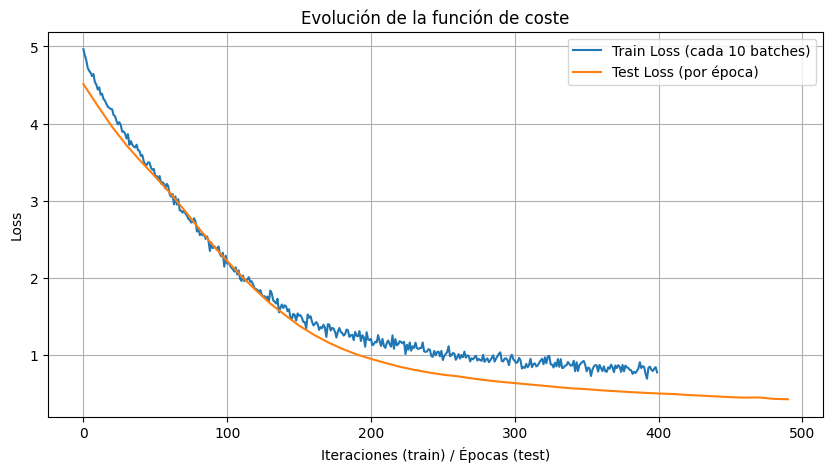

In [20]:
graficas(train_losses, test_losses)

## Inferencia

Calcular accuracy para el conjunto de test.

In [22]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    model.to(device)

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            mask = batch['mask'].to(device)

            outputs = model(inputs, mask)  #(batch_size, seq_len, vocab_size)
            predictions = outputs.argmax(dim=-1)  #(batch_size, seq_len)

            # Comparar predicción con el target donde la máscara es 1 (tenemos que ignorar el padding)
            for pred, tgt, msk in zip(predictions, targets, mask):
                pred_filtered = pred[msk]
                tgt_filtered = tgt[msk]
                correct += (pred_filtered == tgt_filtered).sum().item()
                total += len(tgt_filtered)

    return correct / total

test_accuracy = calculate_accuracy(model1, test_loader,device)
print(f"Precision de Test: {test_accuracy*100:.2f}%")

#precision del 55% malisima

Precision de Test: 84.75%


## Inferencia con otras secuencias

Implementar la función `test_sorting` que recibe el modelo y una secuencia y devuelve la secuencia ordenada.

Realizar pruebas con varias secuencias (3 o 4 son suficientes)  e imprimir los resultados.

In [24]:
def test_sorting(model, input_sequence, device):
    model.eval()  # modo evaluación

    # 1. Pad la secuencia con "zero" hasta MAX_SEQ_LENGTH
    padded_sequence = input_sequence + ["<pad>"] * (MAX_SEQ_LENGTH - len(input_sequence))
    # 2. Convertir palabras a índices
    input_ids = [number_to_idx[word] for word in padded_sequence]
    # 3. Crear máscara (1 donde hay tokens reales, 0 donde hay padding)
    mask = [1 if word != "<pad>" else 0 for word in padded_sequence]
    # 4. Convertir a tensores y llevar al dispositivo
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    mask_tensor = torch.tensor([mask], dtype=torch.bool).to(device)

    # 5. Obtener predicción del modelo
    with torch.no_grad():
        output = model(input_tensor, mask_tensor)  # (1, seq_len, vocab_size)
        predicted_ids = output.argmax(dim=-1)[0]   # quitamos la dimensión batch (queda seq_len)

    # 6. Convertir índices predichos a palabras
    real_length = sum(mask)
    predicted_words = [idx_to_number[idx.item()] for idx in predicted_ids[:real_length]] #Ignoramos las posiciones de padding

    return predicted_words


In [36]:
secuencias = [
    ["forty-two", "eleven", "ninety-nine"],
    ["seventy", "twenty-five", "sixty-one"],
    ["eight", "three", "ten", "two"]
]

for i, seq in enumerate(secuencias):
    ordenada = test_sorting(model1, seq, device)
    print(f"\nSecuencia original {i+1}: {seq}")
    print(f"Secuencia ordenada predicha: {ordenada}")



Secuencia original 1: ['forty-two', 'eleven', 'ninety-nine']
Secuencia ordenada predicha: ['eleven', 'forty-two', 'ninety-nine']

Secuencia original 2: ['seventy', 'twenty-five', 'sixty-one']
Secuencia ordenada predicha: ['twenty-five', 'sixty-one', 'seventy']

Secuencia original 3: ['eight', 'three', 'ten', 'two']
Secuencia ordenada predicha: ['two', 'three', 'three', 'eight']


## Implemenctación de un *Transformer*

En esta sección implementaremos el codificador de un transformer utilizando funciones básicas de Pytorch como nn.Linear. En la siguiente figura se puede ver la arquitectura básica de un condificador de un transformer.


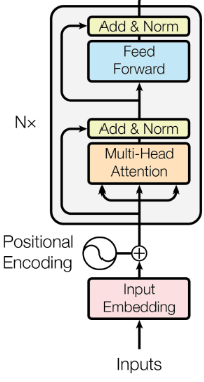

# *Multi-Head Attention*


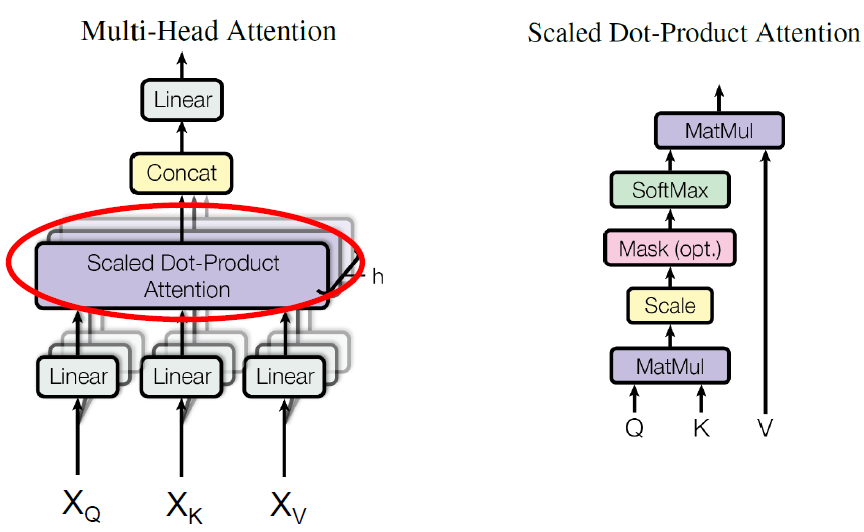

In [41]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model debe ser divisible por num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads  # tamaño de cada cabeza

        # Proyecciones lineales para Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Proyección final después de concatenar cabezas
        self.fc_out = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V: (batch, num_heads, seq_len, head_dim)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (batch, num_heads, seq_len, seq_len)

        if mask is not None:
            # Expandimos dimensiones para que sea compatible con scores (broadcasting)
            # scores: (batch, num_heads, seq_len, seq_len)
            # mask:   (batch, 1, 1, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, float('-inf')) #Aplicamos la mascara

        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)  # (batch, num_heads, seq_len, head_dim)

        return output, attention_weights

    def split_heads(self, x): #Separa el embedding para cada cabeza.
        # x: (batch, seq_len, d_model)
        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)  # (batch, seq_len, num_heads, head_dim)
        return x.transpose(1, 2)  # (batch, num_heads, seq_len, head_dim)

    def combine_heads(self, x): #Une el embedding para cada cabeza.
        # x: (batch, num_heads, seq_len, head_dim)
        batch_size, num_heads, seq_len, head_dim = x.size()
        x = x.transpose(1, 2)  # (batch, seq_len, num_heads, head_dim)
        x = x.contiguous().view(batch_size, seq_len, self.d_model)  # (batch, seq_len, d_model)
        return x

    def forward(self, Q, K, V, mask=None):
        # Q, K, V: (batch, seq_len, d_model)
        Q = self.W_q(Q)  # (batch, seq_len, d_model)
        K = self.W_k(K)
        V = self.W_v(V)

        Q = self.split_heads(Q)  # (batch, num_heads, seq_len, head_dim)
        K = self.split_heads(K)
        V = self.split_heads(V)

        out, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        out = self.combine_heads(out)  # (batch, seq_len, d_model)
        out = self.fc_out(out)  # (batch, seq_len, d_model)

        return out


## Feed Forward

Consiste en dos capas totalmente conectadas con activación tipo ReLU en la primera capa.

In [44]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)   # primera capa: expansión
        self.relu = nn.ReLU()                     # activación no lineal
        self.linear2 = nn.Linear(d_ff, d_model)   # segunda capa: proyección de vuelta a d_model

    def forward(self, x):
        x = self.linear1(x)   # (batch, seq_len, d_ff)
        x = self.relu(x)      # ReLU actúa elemento por elemento
        x = self.linear2(x)   # (batch, seq_len, d_model)
        return x

## Encoder Layer

Cada capa del codificador tendrá la siguiente estructura:
  - `MultiHeadAttention` con dropout
  - `LayerNorm`
  - `FeedForward` con dropout
  - `LayerNorm`

In [47]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout):
        super().__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.feed_forward = FeedForward(d_model, dim_feedforward)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # --- Self-Attention ---
        attn_out = self.self_attention(x, x, x, mask)         # (batch, seq_len, d_model)
        x = self.norm1(x + self.dropout1(attn_out))           # Residual + Norm

        # --- FeedForward ---
        ff_out = self.feed_forward(x)                         # (batch, seq_len, d_model)
        x = self.norm2(x + self.dropout2(ff_out))             # Residual + Norm

        return x


# CustomTransformerSorter

Reimplementar `TransformerSorter` utilizando las capas `EncoderLayer` que acabamos de definir en lugar de utilizar módulos de Pytorch.

In [50]:
class CustomTransformerSorter(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=4, dim_feedforward=512, max_len=10, dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0) # El 0 es padding

        # Positional Encoding como parámetro entrenable
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model))

        # Crear múltiples capas encoder
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Capa de salida: proyecta de d_model al vocabulario
        self.fc_out = nn.Linear(d_model, vocab_size)

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask):
        # x: (batch, seq_len)
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]

        for layer in self.encoder_layers:
            x = layer(x, mask)  # Aplicamos cada encoder layer

        x = self.fc_out(x)  # (batch, seq_len, vocab_size)
        return x


In [52]:
class TransformerSorter(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=4, dim_feedforward=512, max_len=10):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0) # El 0 es padding

        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model)) # los Transformers no tienen un orden implícito en la secuencia, ya que
        #procesan todos los tokens en paralelo, los Positional Encodings, que agregan información sobre la posición de cada token dentro de la secuencia

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        #con nn.TransformerEncoderLayer definimos como va a ser cada capa de encoders y luego definimos cuantas queremos con nn.TransformerEncoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers) #le pasamos como es cada capa y el numero de capas

        self.fc_out = nn.Linear(d_model, vocab_size)  #Capa de salida

        self._init_weights()  # Inicializar pesos

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) #usamos Xavier

    def forward(self, x, mask):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer_encoder(x, src_key_padding_mask=(mask == 0))  # Aplicamos máscara, no lo vimos asiq tampoco se exactamente para que vale
        x = self.fc_out(x)
        return x



Entrenar y calcular *accuracy* para `CustomTransformerSorter` reutilizando `train_model` y `calculate_accuracy`.

In [ ]:
#Creamos esta función debido a que el modelo no aprendía y queríamos encontrar la causa
def train_debug(model, train_loader, device, criterion, optimizer, epochs=500):
    model = model.to(device)

    # Solo usamos UN batch del train_loader
    one_batch = next(iter(train_loader))
    inputs = one_batch['input'].to(device)
    targets = one_batch['target'].to(device)
    # mask = one_batch['mask'].to(device)  # ¡Lo quitamos temporalmente!

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Salida del modelo
        outputs = model(inputs, mask=None)  # SIN máscara

        # Cálculo de la pérdida
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"[Epoch {epoch+1}/{epochs}] Loss: {loss.item():.4f}")
            # Mostramos entrada/salida/target para verificar
            pred = outputs.argmax(dim=-1)  # Predicción como índices
            print("Input:  ", inputs[0].tolist())
            print("Target: ", targets[0].tolist())
            print("Output: ", pred[0].tolist())
            print("-" * 50)



In [60]:

model2 = CustomTransformerSorter(vocab_size= VOCAB_SIZE)

criterion = nn.CrossEntropyLoss(ignore_index=number_to_idx['<pad>']) #hay que ignorar el pad al calcular el loss
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model2.to(device)
train_losses, test_losses = train_model(model2, train_loader, test_loader, device, criterion=criterion, optimizer=optimizer, epochs=50)

Using device: cpu
Epoch [1/50], Val Loss: 3.8053
Epoch [2/50], Val Loss: 3.1596
Epoch [3/50], Val Loss: 2.7747
Epoch [4/50], Val Loss: 2.4819
Epoch [5/50], Val Loss: 2.2469
Epoch [6/50], Val Loss: 2.0315
Epoch [7/50], Val Loss: 1.8217
Epoch [8/50], Val Loss: 1.6360
Epoch [9/50], Val Loss: 1.4839
Epoch [10/50], Val Loss: 1.3487
Epoch [11/50], Val Loss: 1.2344
Epoch [12/50], Val Loss: 1.1274
Epoch [13/50], Val Loss: 1.0307
Epoch [14/50], Val Loss: 0.9571
Epoch [15/50], Val Loss: 0.8707
Epoch [16/50], Val Loss: 0.8095
Epoch [17/50], Val Loss: 0.7517
Epoch [18/50], Val Loss: 0.7011
Epoch [19/50], Val Loss: 0.6569
Epoch [20/50], Val Loss: 0.6174
Epoch [21/50], Val Loss: 0.5813
Epoch [22/50], Val Loss: 0.5514
Epoch [23/50], Val Loss: 0.5165
Epoch [24/50], Val Loss: 0.4889
Epoch [25/50], Val Loss: 0.4617
Epoch [26/50], Val Loss: 0.4322
Epoch [27/50], Val Loss: 0.4111
Epoch [28/50], Val Loss: 0.4029
Epoch [29/50], Val Loss: 0.3733
Epoch [30/50], Val Loss: 0.3590
Epoch [31/50], Val Loss: 0.3394

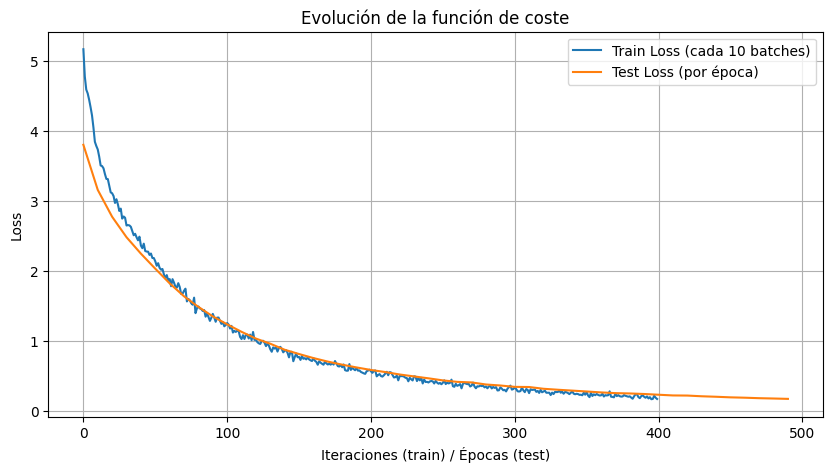

In [61]:
graficas(train_losses, test_losses)

In [62]:
test_accuracy = calculate_accuracy(model2, test_loader,device)
print(f"Precision de Test: {test_accuracy*100:.2f}%")

Precision de Test: 94.45%
